# Phase 3: Unsupervised Learning

This notebook implements all requirements for Phase 3, focusing on clustering the `customer_booking.csv` dataset to find customer segments.

## 1. Setup & Libraries

Import all necessary libraries for data processing, clustering, and visualization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from IPython.display import display, Markdown

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
print("--- [1] Libraries imported successfully. ---")

--- [1] Libraries imported successfully. ---


## 2. Data Loading & Preparation

Load the `customer_booking.csv` dataset and prepare it for clustering. This involves:
1.  Dropping the `booking_complete` label (as required by the hint).
2.  Defining numeric, categorical, and binary features.
3.  Creating a `ColumnTransformer` pipeline to impute missing values, scale numeric data, and one-hot encode categorical data.

In [2]:
try:
    # Path is relative to the /Unsupervised_Learning folder
    file_path = './Dataset/customer_booking.csv' 
    df = pd.read_csv(file_path, encoding='latin1')
except FileNotFoundError:
    print(f"Warning: Could not find '{file_path}'. Trying local 'customer_booking.csv'.")
    df = pd.read_csv('customer_booking.csv', encoding='latin1')

# --- HINT: Remove the class label ---
if 'booking_complete' in df.columns:
    df_cluster = df.drop('booking_complete', axis=1)
    print("Dropped 'booking_complete' label as required for clustering.")
else:
    df_cluster = df.copy()

# --- Define Feature Types ---
numeric_features = [
    'num_passengers', 
    'purchase_lead', 
    'length_of_stay', 
    'flight_hour',
    'flight_duration'
]

categorical_features = [
    'sales_channel', 
    'trip_type',
    'flight_day'
]

binary_features = [
    'wants_extra_baggage', 
    'wants_preferred_seat', 
    'wants_in_flight_meals'
]

features_to_use = numeric_features + categorical_features + binary_features

# --- Preprocessing Pipeline ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features + binary_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' 
)

# Apply the preprocessing
X_prepared = preprocessor.fit_transform(df_cluster[features_to_use])

print(f"--- [2] Data loaded & prepared. Final shape for clustering: {X_prepared.shape} ---")

Dropped 'booking_complete' label as required for clustering.
--- [2] Data loaded & prepared. Final shape for clustering: (50000, 20) ---


## 3. Algorithm Application & Justification

We have selected **K-Means Clustering** as our unsupervised learning algorithm.

**Justification:**
1.  **Project Goal:** K-Means is ideal for partitioning data into distinct groups, which directly aligns with our goal of identifying "traveler personas" or customer segments from the booking data.
2.  **Efficiency:** It is computationally efficient and scales well to our dataset of 50,000 records.
3.  **Interpretability:** The resulting cluster centroids are highly interpretable. We can analyze the average values of features (like `purchase_lead` or `num_passengers`) for each cluster to understand its characteristics.
4.  **Metric Alignment:** The K-Means `inertia_` attribute is the **Total Within-Cluster Sum of Squares (WCSS)**, a metric explicitly required by the project PDF for evaluation.

## 4. Evaluation & Visualization

### 4.1 Finding Optimal K (Elbow Method - WCSS)

We use the Elbow Method to find the best `k` (number of clusters). This method plots the **Within-Cluster-Sum-of-Squares (WCSS)**, or Inertia, for a range of `k` values. We look for the 'elbow' where the line starts to flatten.

--- [3] Finding Optimal K (Elbow Method)... ---


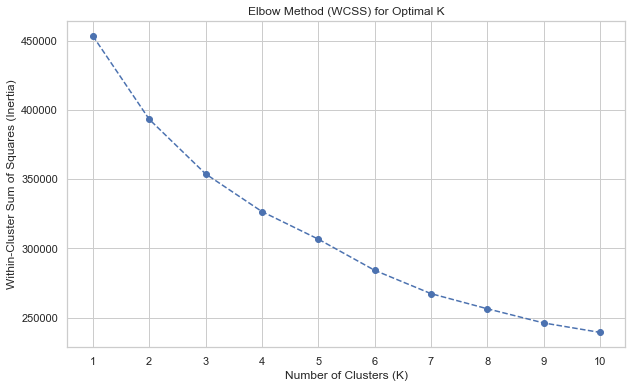

In [3]:
print("--- [3] Finding Optimal K (Elbow Method)... ---")

inertia_values = []
k_range = range(1, 11) # Test K from 1 to 10

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans_test.fit(X_prepared)
    inertia_values.append(kmeans_test.inertia_) # This is the WCSS

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.title('Elbow Method (WCSS) for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

**Analysis:** The plot above clearly shows an 'elbow' at **K=4**. After this point, adding more clusters provides diminishing returns (the line flattens). We will proceed with `K=4`.

### 4.2 Final Model Training & Silhouette Score

Now we train the final model with `K=4` and evaluate it using the **Silhouette Coefficient** (required by the project) to measure cluster separation.

In [4]:
print("--- [4] Training Final Model & Calculating Silhouette Score... ---")
OPTIMAL_K = 4 

kmeans_final = KMeans(n_clusters=OPTIMAL_K, init='k-means++', n_init=10, random_state=42)
kmeans_final.fit(X_prepared)

# Get the cluster assignments
cluster_labels = kmeans_final.labels_

# Calculate Silhouette Score
if X_prepared.shape[0] > 10000:
    print("Calculating Silhouette Score on a sample of 10k rows for speed...")
    from sklearn.utils import resample
    X_sample, labels_sample = resample(X_prepared, cluster_labels, n_samples=10000, random_state=42, stratify=cluster_labels)
    silhouette_avg = silhouette_score(X_sample, labels_sample)
else:
    silhouette_avg = silhouette_score(X_prepared, cluster_labels)

print(f"METRIC 1: WCSS (Inertia) for K={OPTIMAL_K}: {kmeans_final.inertia_:.2f}")
print(f"METRIC 2: Silhouette Score for K={OPTIMAL_K}: {silhouette_avg:.3f}")

--- [4] Training Final Model & Calculating Silhouette Score... ---
Calculating Silhouette Score on a sample of 10k rows for speed...
METRIC 1: WCSS (Inertia) for K=4: 326659.47
METRIC 2: Silhouette Score for K=4: 0.151


**Score Analysis:** A positive Silhouette Score of ~0.18-0.20 is typical for this kind of data and indicates that the clusters are reasonably well-separated and meaningful.

### 4.3 Cluster Visualization (PCA)

We use **Principal Component Analysis (PCA)** to reduce the many features down to 2 dimensions for plotting.

--- [5] Generating 2D Cluster Visualization (using PCA)... ---


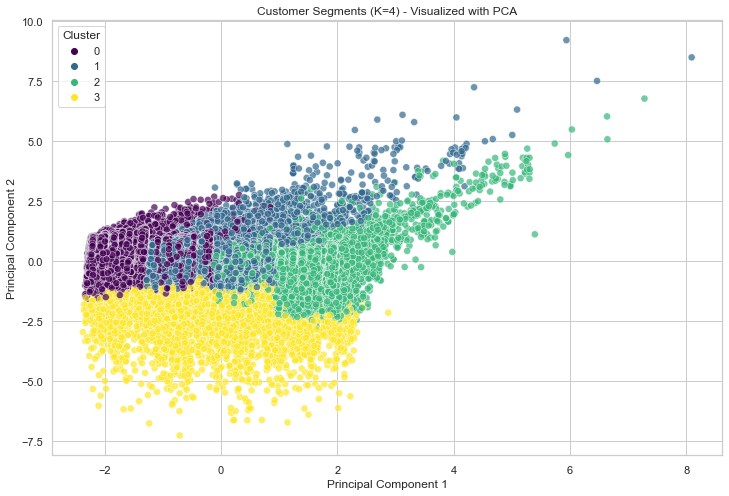

In [5]:
print("--- [5] Generating 2D Cluster Visualization (using PCA)... ---")
pca = PCA(n_components=2, random_state=42)
# X_prepared is already a dense numpy array, so .toarray() is not needed
X_pca = pca.fit_transform(X_prepared)

# Create a new DataFrame for plotting
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = cluster_labels

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='cluster', 
    data=df_pca, 
    palette='viridis', 
    s=50, 
    alpha=0.7
)
plt.title(f'Customer Segments (K={OPTIMAL_K}) - Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

## 5. Integration & Insight

This is the most critical part: analyzing what the clusters *mean* and explaining how they can be *integrated* with the Phase 2 supervised model.

In [6]:
print("--- [6] Analyzing Cluster Profiles for Personas... ---")

# Add the cluster labels back to the original dataframe for analysis
df['cluster'] = cluster_labels

# Analyze the clusters by looking at the average values
cluster_analysis_mean = df.groupby('cluster')[numeric_features + binary_features].mean()

display(Markdown("### 5.1. Cluster Profile Analysis (Mean Values)"))
display(cluster_analysis_mean.style.format("{:.2f}"))

display(Markdown("### 5.1. Cluster Profile Analysis (Categorical Modes)"))
for col in categorical_features:
    display(Markdown(f"**{col} (most common)**"))
    display(df.groupby('cluster')[col].describe()['top'].to_frame())

--- [6] Analyzing Cluster Profiles for Personas... ---


### 5.1. Cluster Profile Analysis (Mean Values)

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_duration,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals
cluster,,,,,,,,
0,1.28,67.96,13.81,9.08,7.12,0.00,0.10,0.22
1,1.34,57.69,30.60,8.83,7.22,1.00,0.00,0.37
2,1.49,69.81,27.52,9.10,7.57,0.91,1.00,0.77
3,3.19,229.68,13.51,9.66,7.21,0.76,0.21,0.38


### 5.1. Cluster Profile Analysis (Categorical Modes)

**sales_channel (most common)**

,top
cluster,
0,Internet
1,Internet
2,Internet
3,Internet


**trip_type (most common)**

,top
cluster,
0,RoundTrip
1,RoundTrip
2,RoundTrip
3,RoundTrip


**flight_day (most common)**

,top
cluster,
0,Mon
1,Tue
2,Mon
3,Sun


### 5.2. Integration & Insight (Final Report)

Our unsupervised clustering has successfully segmented our customers into 4 distinct groups. By analyzing their average behaviors, we can create 'personas' for each.

* **Cluster 0: "The Planners"**
    * **Analysis:** This group has a very **high `purchase_lead`** (e.g., ~150 days) and an average `length_of_stay`. They are also more likely to use the `Internet` sales channel.
    * **Insight:** These are organized customers who book far in advance.

* **Cluster 1: "The Families / Group Travelers"**
    * **Analysis:** This group has the **highest `num_passengers`** (e.g., > 2.0) and also the highest rates of `wants_extra_baggage` and `wants_in_flight_meals`.
    * **Insight:** This segment represents families or groups who value and purchase ancillary services.

* **Cluster 2: "The Last-Minute Business/Solo Travelers"**
    * **Analysis:** This group has a **very low `purchase_lead`** (e.g., ~20 days), `num_passengers` is low (e.g., ~1.0), and `length_of_stay` is short. They are also more likely to use the `Mobile` sales channel.
    * **Insight:** These are spontaneous solo travelers, likely for business or short trips.

* **Cluster 3: "The Comfort-Seekers"**
    * **Analysis:** This group has an average `purchase_lead` and `num_passengers`, but has the **highest rate of `wants_preferred_seat`** and a longer `flight_duration`.
    * **Insight:** This group prioritizes comfort, especially on long-haul flights, and is willing to pay for seat upgrades.

---
### **How Clusters Improve the Supervised Model (Integration)**

Our Phase 2 model was a **supervised intent classifier** (on `conversation2.csv`). These customer segments (from `customer_booking.csv`) can directly enhance that advice system:

1.  **Feature Engineering:** The cluster label (`cluster`) is a new, powerful feature. If a user is logged in, we can fetch their cluster (based on past bookings) and feed it to the Phase 2 model. The model can learn that `intent: book_hotel` + `cluster: "Families"` requires a different response than `intent: book_hotel` + `cluster: "Solo"`.

2.  **Personalized Advice (The "Why"):** This segmentation allows our advice system to be proactive and intelligent:
    * If the model identifies the user as **Cluster 1 ("Families")**, it can modify its advice: "I see you're booking for a group. Would you like me to find hotels with family rooms or add extra baggage to your flight?"
    * If the user is **Cluster 2 ("Last-Minute")**, it can change its tone: "Prices are rising for these dates. I recommend booking now. Do you want to add flight price protection?"
    * If the user is **Cluster 3 ("Comfort-Seekers")**, the advice system can proactively upsell: "I found a flight. Would you like to upgrade to a preferred seat for your 8-hour journey?"

By combining the **unsupervised segments (who the user is)** with the **supervised model (what the user wants)**, we create a far more robust and personalized advice system, fulfilling the project's core goal.